In [17]:
import glob
import os
import numpy as np
import pandas as pd

columns = "HR|O2Sat|Temp|SBP|MAP|DBP|Resp|EtCO2|BaseExcess|HCO3|FiO2|pH|PaCO2|SaO2|AST|BUN|Alkalinephos|Calcium|Chloride|Creatinine|Bilirubin_direct|Glucose|Lactate|Magnesium|Phosphate|Potassium|Bilirubin_total|TroponinI|Hct|Hgb|PTT|WBC|Fibrinogen|Platelets|Age|Gender|Unit1|Unit2|HospAdmTime|ICULOS|SepsisLabel"
columns = columns.split('|')
print(len(columns))
vital_columns = "HR|O2Sat|Temp|SBP|MAP|DBP|Resp|EtCO2".split("|")

# file_name = 'p019636.psv'
# # file_name = 'p000001.psv'
# current_dir = os.getcwd()
# file_path = os.path.join(current_dir, './data/training/', file_name)
# # print(file_path)
# # with open(file_path, 'r') as infile:

41


In [95]:
def process_input_file(input_file_path):
    """
    Vitals data will be imputed by backfilling (then forward-filling to catch cases where vitals are missing on last rows). 
    All other data will receive 0s for empty values.
    """
    # Load PSV file into a DataFrame
    data = np.genfromtxt(input_file_path, delimiter='|', skip_footer = 1)
    df = pd.DataFrame(data, columns=columns)
    df.replace('nan',np.nan)

    # Remove Administrative identifiers so our model doesn't learn spurious patterns from it
    df = df.drop(columns=['Unit1', 'Unit2'])

    # Use backfill to fill in vitals columns
    vitals = df[vital_columns]
    vitals = vitals.fillna(method='bfill').fillna(method='ffill').fillna(value=0)
    
    # Change Sepsis to integer
    df['SepsisLabel'] = df['SepsisLabel'].astype(str)
    df['SepsisLabel']= df['SepsisLabel'].replace({'0.0':0,'nan':0,'1.0':1})
    df['SepsisLabel'] = df['SepsisLabel'].astype('uint8')
    
    # Fill all other columns with zeros for missing data
    df[vital_columns] = vitals
#     df = df.fillna(value=0) # removed this so we can normalize with nanmean

#     narr = df.to_numpy()
    return df

In [15]:
def pad_slice_normalize_array(input_df, means, std_devs, output_height=24):
    as_np = input_df.to_numpy()[-1 * output_height:, :]
    how_much_pad = output_height - as_np.shape[0]
    padded = np.pad(as_np, [(how_much_pad, 0),(0,0)], mode='constant', constant_values=np.nan)
    targets = np.nan_to_num(padded[:, -1]).astype('bool')
#     print(targets)
#     if targets.any(): print(True)
#     if padded[:, -1].any(): print(True)
    padded -= means
    padded /= std_devs
    padded = np.nan_to_num(padded)
#     padded[:, -1] = targets
    return padded[:, :-1], np.array([targets.any()])

In [10]:
import random
file_list = glob.glob('./training data/training/*.psv')
random.shuffle(file_list)

training_data = file_list[:12336]
validation_data = file_list[12336:16336]
test_data = file_list[16336:20336]

print(len(training_data))
print(len(validation_data))
print(len(test_data))

12336
4000
4000


In [89]:
training_data_frames = []

for path in training_data:
    df = process_input_file(path)
    training_data_frames.append(df)

full_training_data = [x.to_numpy() for x in training_data_frames]
concat_array = np.concatenate(full_training_data)

# print(concat_array.shape)

means = np.nanmean(concat_array, axis=0)
std_devs = np.nanstd(concat_array, axis=0)

In [90]:
def make_X_y(paths, means, std_devs, oversample=False):
    dataframes = [process_input_file(path) for path in paths]
    if oversample is True:
        sepsis_dataframes = []
        for item in dataframes:
            np_item = item.to_numpy()
            targets = np_item[:, -1].astype('bool')
            if targets.any():
                sepsis_dataframes.append(item)
        dataframes += sepsis_dataframes
        random.shuffle(dataframes)
            
    data_as_tuples = [pad_slice_normalize_array(x, means, std_devs) for x in dataframes]
    X = [x[0] for x in data_as_tuples]
    y = [x[1] for x in data_as_tuples]
    return np.stack(X), np.stack(y)

In [91]:
X_train, y_train = make_X_y(training_data, means, std_devs, oversample=True)

print(X_train.shape)
print(y_train.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


(13452, 24, 38)
(13452, 1)


In [ ]:
# X_val, y_val = make_X_y(validation_data, means, std_devs)

print(X_val.shape)
print(y_val.shape)

In [94]:
X_test, y_test = make_X_y(test_data, means, std_devs)

print(X_test.shape)
print(y_test.shape)

(4000, 24, 38)
(4000, 1)


In [98]:
# Setup for deep learning
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import keras
from keras import backend as K

cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
cfg.gpu_options.per_process_gpu_memory_fraction=0.333
K.set_session(K.tf.Session(config=cfg))

Using TensorFlow backend.


In [99]:
print("Ready")

Ready


In [104]:
from keras import models
from keras.layers import LSTM, Dense, Dropout

model = models.Sequential()
model.add(LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(24, 38)))
model.add(LSTM(256, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 24, 256)           302080    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
__________

In [105]:
trained_model = model.fit(X_train, 
                          y_train, 
                          batch_size=256,
                          epochs=15,
                          verbose=1,
                          validation_data=(X_val, y_val))

Train on 13452 samples, validate on 4000 samples
Epoch 1/15
13452/13452 [==============================] - 861s 64ms/step - loss: 0.3952 - acc: 0.8538 - val_loss: 0.2185 - val_acc: 0.9373
Epoch 2/15
13452/13452 [==============================] - 832s 62ms/step - loss: 0.3146 - acc: 0.8909 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 3/15
13452/13452 [==============================] - 836s 62ms/step - loss: 0.2806 - acc: 0.9049 - val_loss: 0.1882 - val_acc: 0.9457
Epoch 4/15
13452/13452 [==============================] - 841s 62ms/step - loss: 0.2652 - acc: 0.9084 - val_loss: 0.1629 - val_acc: 0.9533
Epoch 5/15
13452/13452 [==============================] - 850s 63ms/step - loss: 0.2546 - acc: 0.9127 - val_loss: 0.1649 - val_acc: 0.9513
Epoch 6/15
13452/13452 [==============================] - 833s 62ms/step - loss: 0.2443 - acc: 0.9145 - val_loss: 0.1881 - val_acc: 0.9532
Epoch 7/15
13452/13452 [==============================] - 835s 62ms/step - loss: 0.2309 - acc: 0.9182 - val_loss: 0.1

In [106]:
# Plot the training curves and evaluate accuracy

hdf = pd.DataFrame(data=trained_model.history)
# print(hdf.head)
# for col in ['loss', 'acc', 'precision', 'recall', 'f1score']:
for col in ['loss', 'acc']:
    ax = hdf[[col, 'val_'+col]].plot()
    _ = ax.set_xlabel('epoch')
    _ = ax.set_title(col)
    
print("""test loss: %.2f
test accuracy: %.2f
""" % tuple(model.evaluate(X_val, y_val)))

4000/4000 [==============================] - 145s 36ms/step
test loss: 0.16
test accuracy: 0.95



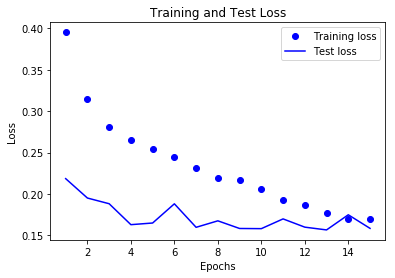

In [109]:
import matplotlib.pyplot as plt
history_dict=hdf
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Test loss')
plt.title("Training and Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

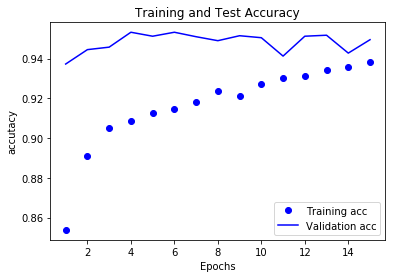

In [111]:
acc_values=history_dict['acc']
val_acc_values=history_dict['val_acc']
plt.plot(epochs,acc_values,'bo',label='Training acc')
plt.plot(epochs,val_acc_values,'b',label='Validation acc')
plt.title("Training and Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('accutacy')
plt.legend()
plt.show()

In [113]:
y_val_prob = model.predict(X_val)
# y_val_pred[:50]

In [114]:
# y_val_pred = y_val_pred.astype('bool')

y_val_pred = [True if x>0.5 else False for x in y_val_prob]

In [115]:
from sklearn.metrics import confusion_matrix
conf_mtrx = confusion_matrix(y_val, y_val_pred)
print(conf_mtrx)
tn, fp, fn, tp = conf_mtrx.ravel()
print(tn, fp, fn, tp)
# First model results:   3640 24 180 156, this model had dropout
# Second model results:  3640 24 165 171, this model removed the dropout to deliberately overfit
# Third model results:   3645 19 177 159, this model added a second LSTM and a third Dense layer
# Fourth model results:  3584 34 172 210, this model switched from 12 hours of data per patient to 24 hours of data per patient
# Fifth model results:   3584 34 162 220, this model increases nodes in the first Dense layer from 32 to 64
# Sixth model results:   3595 23 173 209, this model doubles the nodes in every layer (dramatically increasing # of parameters)
# Seventh model results: 3603 15 185 197, add more dropout layers (for regularization) and increase to 15 epochs
# Eighth model results:  3586 57 140 217, add oversampling (double the number of positive classes)
# Ninth model results:   3603 40 165 192, add more nodes to each layer, but cut down to 5 epochs
# Tenth model results:   3593 50 154 203, cut second LSTM layer to 128 nodes, increase to 15 epochs
# 11th model results:    3568 75 150 207, cut out second LSTM layer, removed dropout layers
# 12th model results: , add 2nd LSTM Layer back

[[3584   87]
 [ 115  214]]
3584 87 115 214


In [116]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_val, y_val_pred))



0.9495
